# Map label cell to cell in cancer or stroma

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sys, os
#from cellpose import io
from skimage import io
from skimage.measure import label, regionprops

other_dir_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(other_dir_path)

import IMCprocess.spatial_analysis.mask_utils as mu
import IMCprocess.utils.utils as ut

## import cell data from mask

In [2]:
cell_in_reg = ut.read_pickle_obj('output_obj/01cell_data.pkl')

In [3]:
cell_in_reg

,cells_in_stroma,cells_in_cancer,cells_in_cancer&tissue,num_cells_in_stroma,num_cells_in_cancer,num_cells_in_cancer&tissue
0,"[1, 3, 4, 5, 9, 10, 12, 15, 18, 19, 23, 26, 27...","{1: [2, 8, 14, 21, 22, 25, 29, 30, 31, 32, 38,...","[2, 6, 7, 8, 11, 13, 14, 16, 17, 20, 21, 22, 2...",2114,29,2463


## import label object (level1)

In [4]:
data_path = '/Users/pattama/Desktop/UiB/cancer/example_share_code/share_with_vladan/mask_analysis/example_data/'
data_level1 = ut.read_pickle_obj(data_path+'00hanna_adata_totalNB_obj_Level1.pkl')

In [5]:
# Get only the object for image R2_002
# You can change image name to get other images
obj_level1 = data_level1.adata_dict['level1']
obj_R2_002_lev1 = obj_level1[obj_level1.obs['img_id'] == 'R2_002']

In [6]:
# Check how many cell in each cell types in this image
obj_R2_002_lev1.obs.level1_annotated.value_counts()

Immune    1977
Ep        1363
Undef      482
Fibro      450
Ves        171
Amb        134
Name: level1_annotated, dtype: int64

## Map level1 cells in stroma, cancer

In [27]:
def get_celltype_fraction(obs_object, col_label, cell_in_reg_df, col_cell_type):
    obs_df = obs_object.copy()
    cellid = cell_in_reg_df.loc[0, col_cell_type]
    if isinstance(cellid, dict):
        cellid_list = []  # The target list to merge all the values into

        # Iterate through the values of the dictionary
        for lst in cellid.values():
            cellid_list.extend(lst)
    else:
        cellid_list = cellid

    # add label column to obs for mapping with cell_data
    obs_df['label'] = np.array(range(1, len(obs_df)+1))
    #How many cells for each cell types in stroma?
    obs_df[obs_df['label'].isin(cellid_list)][col_label].value_counts()

    fraction_df = pd.DataFrame(obs_df[obs_df.label.isin(
        cellid_list)].level1_annotated.value_counts(
            normalize=True)).rename(columns={'level1_annotated':'fraction_'+ col_cell_type})
    return fraction_df

def plt_fraction_df(fraction_df, output_file):
    fraction_df.plot(kind='bar')
    # Add labels to the bars
    for i in range(len(fraction_df)):
        label = round(fraction_df.iloc[:,0][i], 2)  # Round value to one decimal place
        plt.text(i, fraction_df.iloc[:,0][i] + 0.01, label, ha='center')
    plt.savefig(output_file, dpi=300, bbox_inches='tight')


In [28]:

fraction_stroma = get_celltype_fraction(obj_R2_002_lev1.obs, 'level1_annotated', cell_in_reg, 'cells_in_stroma')
fraction_stroma

,fraction_cells_in_stroma
Immune,0.675024
Fibro,0.151845
Undef,0.075686
Ves,0.059130
Amb,0.035005
Ep,0.003311


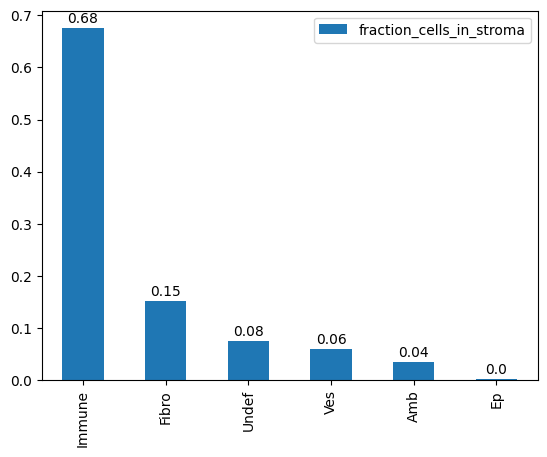

In [30]:
plt_fraction_df(fraction_stroma, 'output/02fraction_cells_in_stroma.png')

In [16]:
fraction_cancer = get_celltype_fraction(obj_R2_002_lev1.obs, 'level1_annotated', cell_in_reg, 'cells_in_cancer')
fraction_cancer

The object is a dictionary (dict).


,fraction_cells_in_cancer
Ep,0.550548
Immune,0.223305
Undef,0.130735
Fibro,0.052375
Amb,0.024361
Ves,0.018676


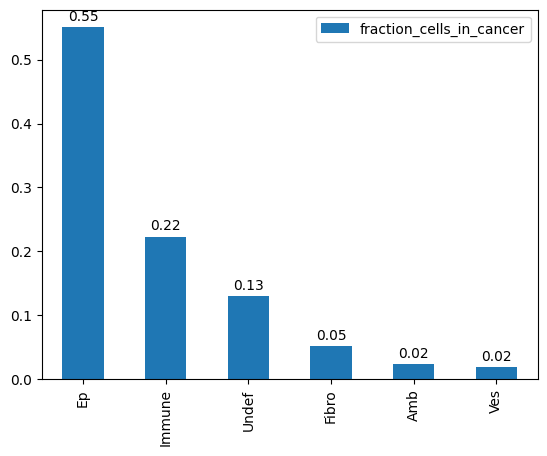

In [31]:
plt_fraction_df(fraction_cancer, 'output/02fraction_cells_in_cancer.png')